# Deep Learning with PyTorch : Build a Generative Adversarial Network

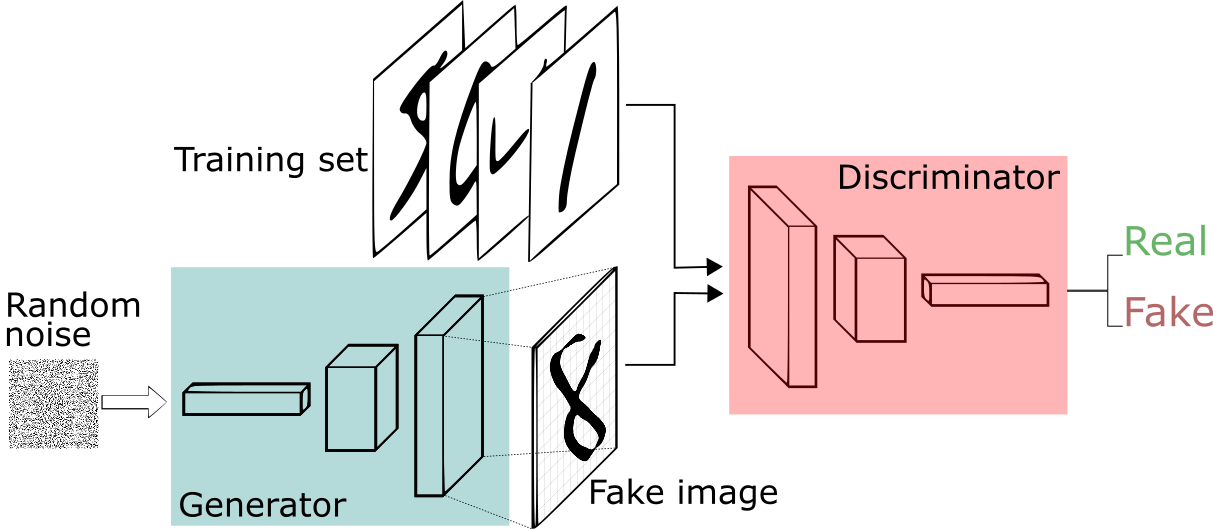

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda' #image = image.to(device)
batch_size = 128 #trainloader , training loop
noise_dim = 64 # generator model
# optimizer parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20



# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor(), #(h,w,c) ->(c,h,w))
])

In [ ]:
trainset = datasets.MNIST('MNIST/' , download = True, train = True, transform = train_augs)

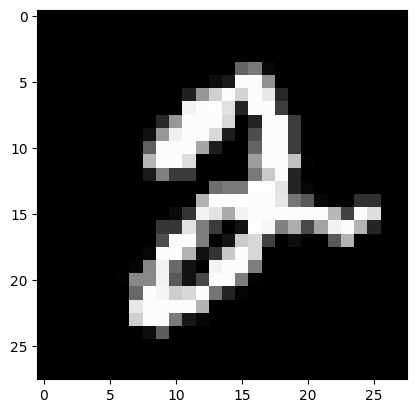

In [ ]:
image , label = trainset[5]
plt.imshow(image.squeeze(), cmap= 'gray')

In [ ]:
print("Toal images present in trainset : ",len(trainset))

Toal images present in trainset :  60000


# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
print("Total batches present in trainloader : ",len(trainloader))

Total batches present in trainloader :  469


In [ ]:
dataiter = iter(trainloader)
images , _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

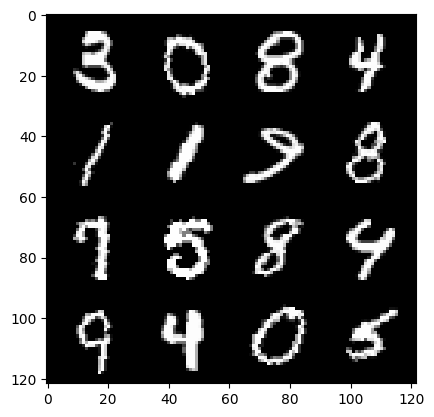

In [ ]:
show_tensor_images(images , num_images=16)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size ,stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size , stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator , self).__init__()
    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)
  def forward(self, images):
      x1 = self.block_1(images)
      x2 = self.block_2(x1)
      x3 = self.block_3(x2)
      x4 = self.flatten(x3)
      x5 = self.linear(x4)
      return x5


In [ ]:
D = Discriminator()
D.to(device)
summary(D , input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator , self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)
    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)
  def forward(self, r_noise_vec):
    #(bs , noise_dim) --> (bs, noise,dim , 1 , 1)
      x= r_noise_vec.view(-1, self.noise_dim, 1, 1)
      x1 = self.block_1(x)
      x2 = self.block_2(x1)
      x3 = self.block_3(x2)
      x4 = self.block_4(x3)
      return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)
summary(G , input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss
def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters() , lr = lr, betas = (beta_1 , beta_2))
G_opt = torch.optim.Adam(G.parameters() , lr = lr, betas = (beta_1 , beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 0 | D_loss: 0.6692 | G_loss: 0.7124


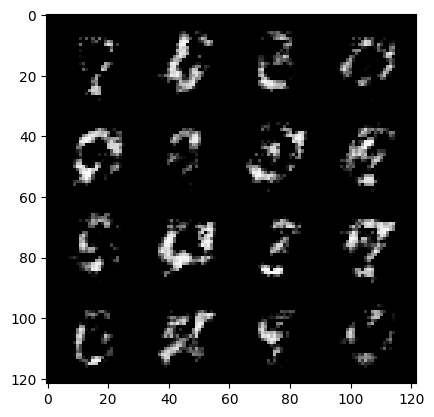

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.6666 | G_loss: 0.7220


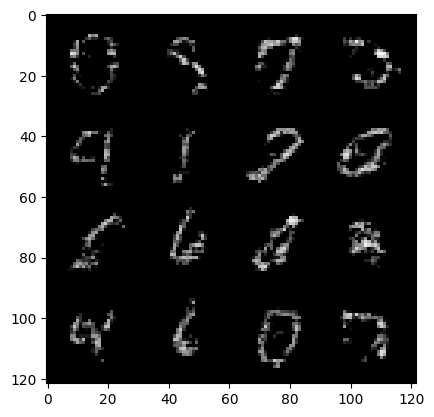

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.6089 | G_loss: 0.7928


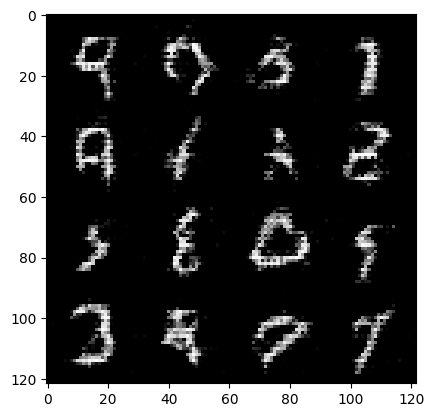

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.5587 | G_loss: 0.8693


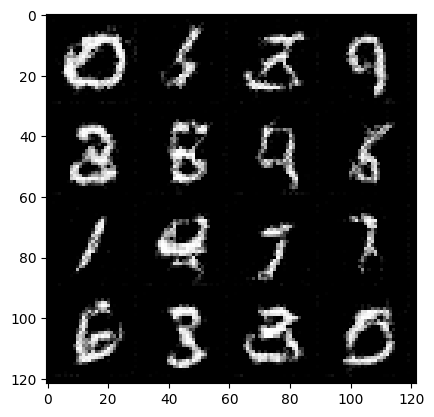

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.5344 | G_loss: 0.9246


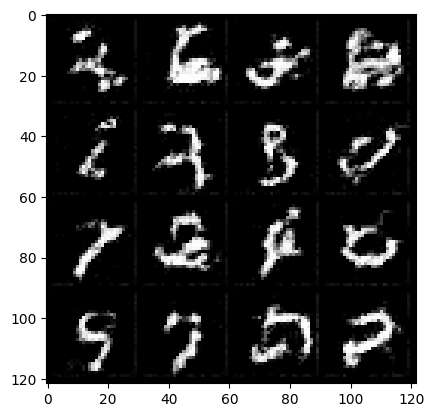

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.5323 | G_loss: 0.9512


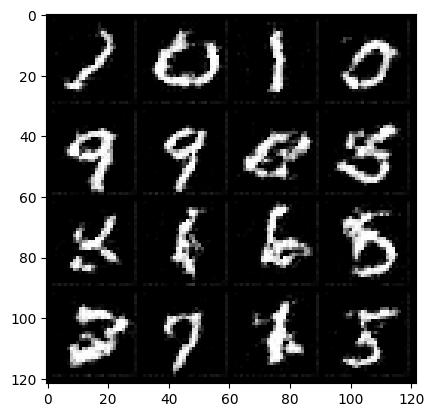

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.5397 | G_loss: 0.9589


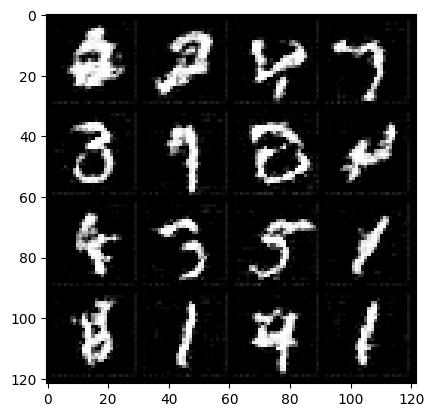

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.5554 | G_loss: 0.9444


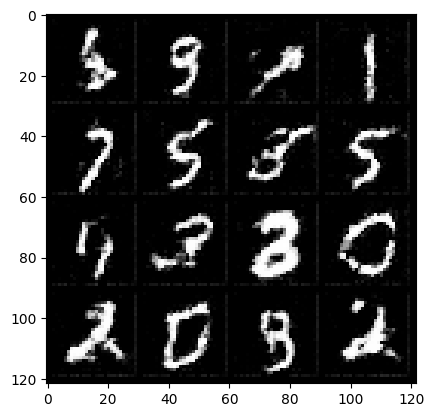

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.5771 | G_loss: 0.9203


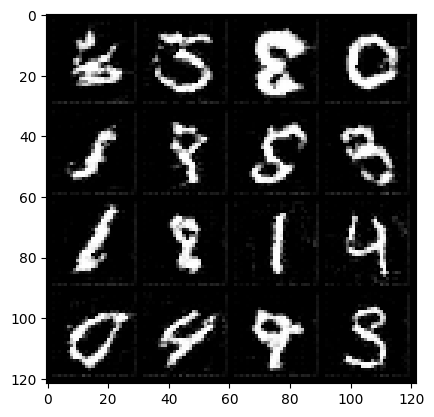

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.5944 | G_loss: 0.9039


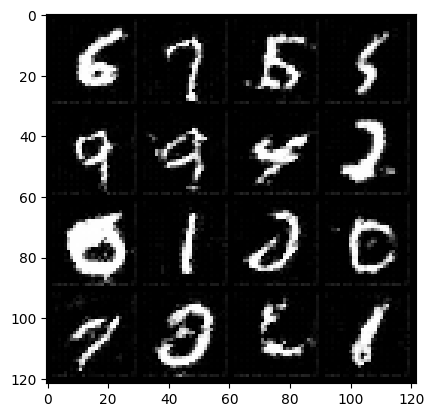

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.6039 | G_loss: 0.8892


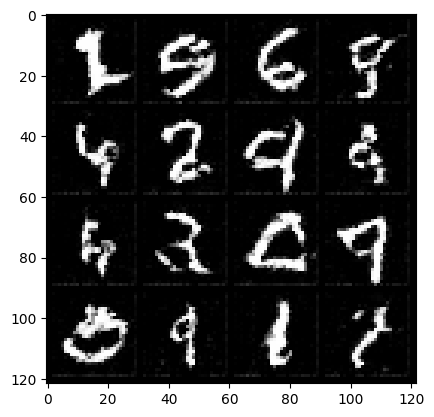

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.6155 | G_loss: 0.8706


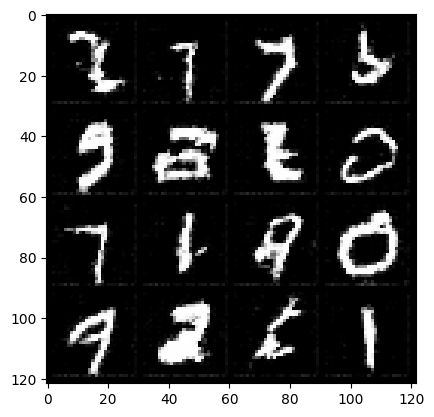

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.6231 | G_loss: 0.8619


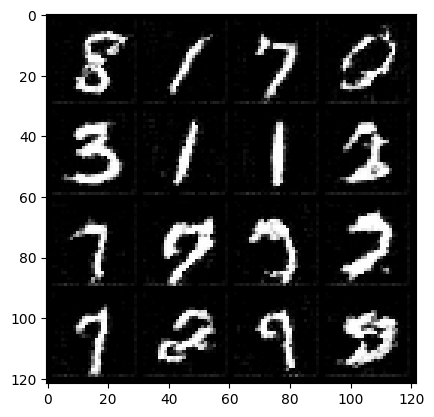

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.6281 | G_loss: 0.8543


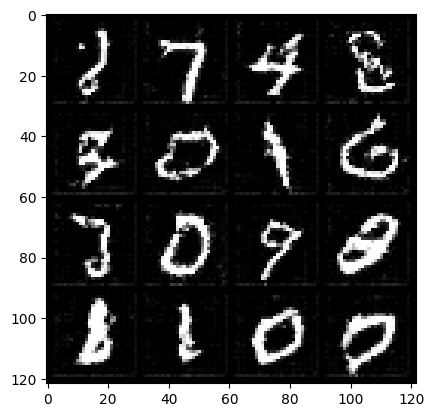

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.6331 | G_loss: 0.8435


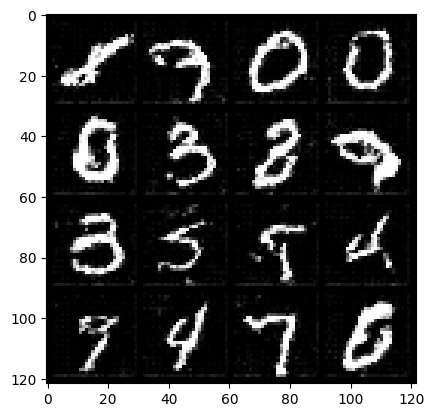

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.6349 | G_loss: 0.8385


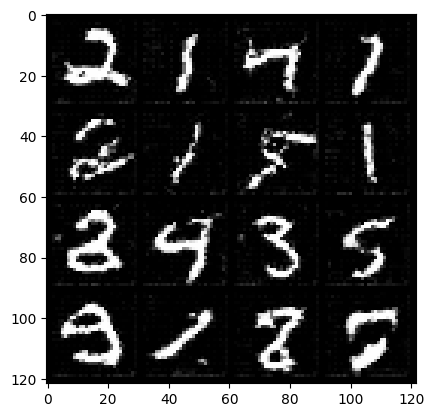

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.6388 | G_loss: 0.8317


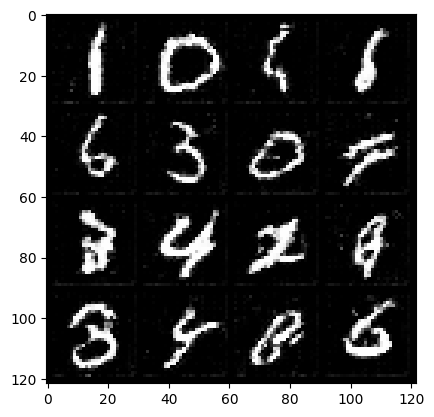

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.6392 | G_loss: 0.8283


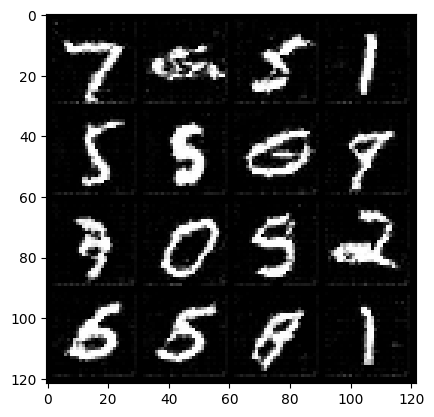

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.6414 | G_loss: 0.8246


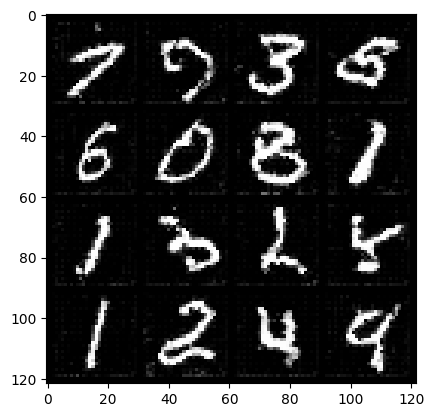

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.6412 | G_loss: 0.8234


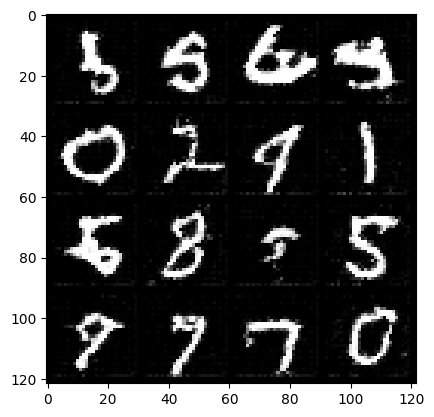

In [ ]:
for i in range(epochs):
    total_d_loss = 0
    total_g_loss = 0
    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device=device)

        # Find loss and update the weights for D
        D_opt.zero_grad()
        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)
        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)
        D_loss = (D_fake_loss + D_real_loss) / 2
        total_d_loss += D_loss.item()
        D_loss.backward()
        D_opt.step()

        # Find loss and update the weights for G
        G_opt.zero_grad()
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)
        total_g_loss += G_loss.item()
        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print(f"Epoch: {i} | D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f}")
    show_tensor_images(fake_img)


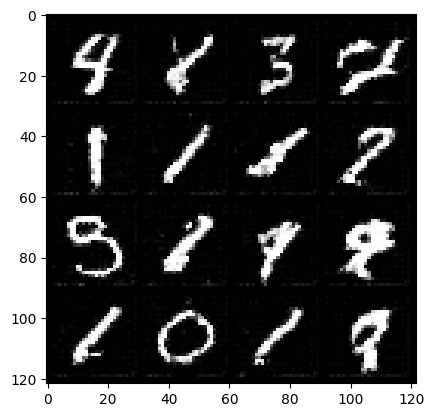

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya